<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/IsolationForest_ring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Isolation Forest による異常検知（リング状クラスタ）
# 手順:
# 1) リング状の「正常」で学習、テストに「正常+内側/外側の異常」
# 2) 学習統計量で Z 標準化
# 3) IsolationForest の score_samples を反転（大きいほど異常）
# 4) 学習スコアの上位 α 分位点をしきい値にして判定
# 5) 図: 散布図+等高線（しきい値）, スコアのヒスト
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

np.random.seed(0)


In [2]:
# ===== パラメータ =====
alpha = 0.93
n_train = 600
n_test_norm = 300
n_test_out  = 60     # 内側30 + 外側30
r0 = 6.0
sigma_r = 0.5


In [3]:
# ===== データ生成（リング=正常 / 内外の異常）=====
def sample_ring(n, r0=6.0, sigma_r=0.5):
    theta = np.random.uniform(0, 2*np.pi, size=n)
    r = r0 + np.random.normal(0, sigma_r, size=n)
    return np.c_[r*np.cos(theta), r*np.sin(theta)]

def sample_circle(n, r_mean, r_std):
    theta = np.random.uniform(0, 2*np.pi, size=n)
    r = np.random.normal(r_mean, r_std, size=n)
    return np.c_[r*np.cos(theta), r*np.sin(theta)]

train = sample_ring(n_train, r0, sigma_r)                 # 学習: 正常のみ
test_norm = sample_ring(n_test_norm, r0, sigma_r)         # テスト: 正常
test_in  = sample_circle(n_test_out//2, r_mean=1.0,  r_std=0.5)   # 内側の異常
test_out = sample_circle(n_test_out//2, r_mean=10.0, r_std=0.7)   # 外側の異常
test = np.vstack([test_norm, test_in, test_out])
labels = np.hstack([np.zeros(len(test_norm), dtype=int),
                    np.ones(len(test_in)+len(test_out), dtype=int)])  # 0=正常,1=異常

In [4]:
# ===== 標準化（学習統計量のみ）=====
mu_hat = train.mean(axis=0)
std_hat = train.std(axis=0, ddof=1)
std_hat = np.where(std_hat==0, 1.0, std_hat)
train_z = (train - mu_hat)/std_hat
test_z  = (test  - mu_hat)/std_hat

In [5]:
# ===== Isolation Forest 学習 & スコア（大きいほど異常）=====
clf = IsolationForest(n_estimators=300, random_state=0)
clf.fit(train_z)
score_train = -clf.score_samples(train_z)
score_test  = -clf.score_samples(test_z)

# しきい値（学習スコアの上位 α 分位点）
finite_train = np.isfinite(score_train)
thr = np.quantile(score_train[finite_train], alpha)
pred = (score_test > thr).astype(int)

In [6]:
# ===== 簡単な集計 =====
tp = ((pred==1) & (labels==1)).sum()
fp = ((pred==1) & (labels==0)).sum()
fn = ((pred==0) & (labels==1)).sum()
precision = tp/(tp+fp) if (tp+fp)>0 else 0.0
recall    = tp/(tp+fn) if (tp+fn)>0 else 0.0
print(f"[IsolationForest] alpha={alpha}")
print(f"threshold (train quantile): {thr:.4f}")
print(f"TP={tp}, FP={fp}, FN={fn}")
print(f"precision={precision:.3f}, recall={recall:.3f}")

[IsolationForest] alpha=0.93
threshold (train quantile): 0.5398
TP=60, FP=27, FN=0
precision=0.690, recall=1.000


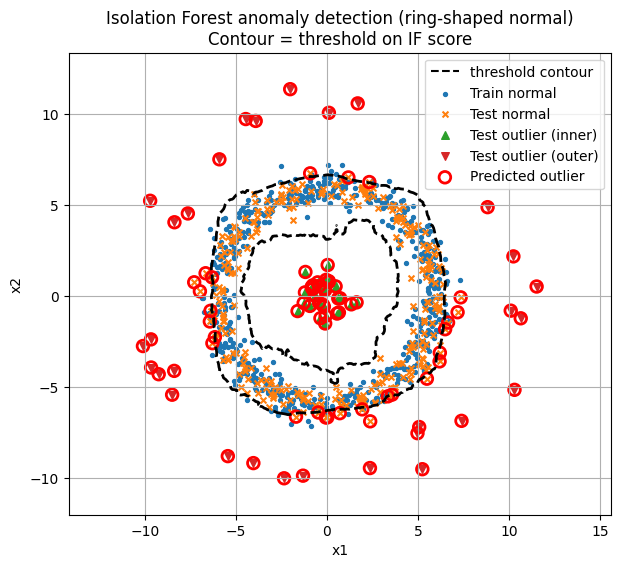

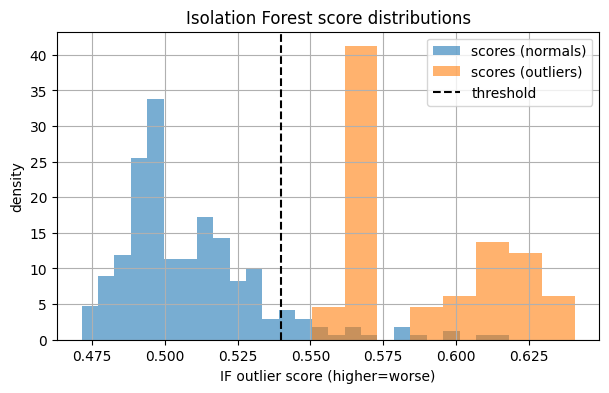

In [7]:
# ===== 可視化：散布図＋等高線 =====
x_min, y_min = (np.min(np.vstack([train, test]), axis=0) - 2)
x_max, y_max = (np.max(np.vstack([train, test]), axis=0) + 2)
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 220),
                     np.linspace(y_min, y_max, 220))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_z = (grid - mu_hat)/std_hat
score_grid = -clf.score_samples(grid_z).reshape(xx.shape)

plt.figure(figsize=(7,6))
plt.contour(xx, yy, score_grid, levels=[thr], linestyles='--', linewidths=2, colors='k')
plt.plot([], [], 'k--', label="threshold contour")  # 凡例用ダミー線
plt.scatter(train[:,0], train[:,1], s=8,  label="Train normal")
plt.scatter(test_norm[:,0], test_norm[:,1], s=18, marker='x', label="Test normal")
plt.scatter(test_in[:,0],  test_in[:,1],  s=30, marker='^', label="Test outlier (inner)")
plt.scatter(test_out[:,0], test_out[:,1], s=30, marker='v', label="Test outlier (outer)")
flag_idx = np.where(pred==1)[0]
plt.scatter(test[flag_idx,0], test[flag_idx,1], s=70, facecolors='none',
            edgecolors='red', linewidths=2, label="Predicted outlier")
plt.title("Isolation Forest anomaly detection (ring-shaped normal)\nContour = threshold on IF score")
plt.xlabel("x1"); plt.ylabel("x2"); plt.legend(); plt.grid(True); plt.axis('equal'); plt.show()

# ===== スコアのヒスト（可視化用クリップ）=====
s_norm = score_test[(labels==0) & np.isfinite(score_test)]
s_out  = score_test[(labels==1) & np.isfinite(score_test)]
if len(s_norm)==0 and len(s_out)==0:
    print("（可視化できる有効なスコアがありませんでした）")
else:
    lo = np.nanpercentile(score_test, 0.5); hi = np.nanpercentile(score_test, 99.5)
    plt.figure(figsize=(7,4))
    plt.hist(s_norm, bins=30, density=True, alpha=0.6, label="scores (normals)", range=(lo,hi))
    plt.hist(s_out,  bins=15, density=True, alpha=0.6, label="scores (outliers)", range=(lo,hi))
    plt.axvline(min(max(thr,lo),hi), linestyle='--', color='k', label="threshold")
    plt.title("Isolation Forest score distributions"); plt.xlabel("IF outlier score (higher=worse)")
    plt.ylabel("density"); plt.legend(); plt.grid(True); plt.show()
